In [2]:
import random
import csv
import math
import numpy as np
import time
import operator
import matplotlib.pyplot as plt
import cPickle as pickle

In [4]:
import heapq

# Load Stored Live Edges

In [5]:
live_edges_200k_point001_point3 = pickle.load(open("live_edges_200k_point001_point3", "rb"))
print "ni hao"
live_edges_200k_point001_point5 = pickle.load(open("live_edges_200k_point001_point5", "rb"))
print "hello"

live_edges_200k_point005_point3 = pickle.load(open("live_edges_200k_point005_point3", "rb"))
print "hi"

live_edges_200k_point005_point5 = pickle.load(open("live_edges_200k_point005_point5", "rb"))


ni hao
hello
hi


# CELF

In [6]:
def celf_population_live_edges(p_initial_infect, p_infect, lists_infected_nodes, num_detectors, seed=0, n=2029, debug=False):
    
    runs_per_marginal_node = len(lists_infected_nodes)
    
    print 'Running CELF to minimize population affected w/ live edges'
    results = open("CELF_population_live_edge.txt", "w")
    results.write("P_infect = " + str(p_infect) + " P_initial_infect = " + str(p_initial_infect) + " Runs per marginal node = " + str(runs_per_marginal_node))
    results.write("\nNode ID\tReward so Far\tMarginal gain\tRuntime (minutes)\n")
    
    final_population = []
    final_runtimes = []
    
    rewards_so_far = sum( [ len(infected_ids)  for infected_ids in lists_infected_nodes ]) / float(runs_per_marginal_node) # population affected w/o detectors
    
    marginals = [] # heap to track marginals
    start_time = time.time()
    
    # we are calculated population saved
    # if the detector is in the infected nodes, we take the index of the detector b/c the infected nodes are in chronological order + 1 - length to represent how many we saved
    # if not, we just take 0 b/c we didnt save any
    # select the first node by exhuastively computing all marginal benefits
    # our metric = (population affected w/ detector) - population affected w/o detector
    # we are trying to minimize this metric
    for potential_detector in range(1,n+1): # calculate marginals for each node
        runs = [infected_ids.index(potential_detector)+1 if potential_detector in infected_ids else len(infected_ids) for infected_ids in lists_infected_nodes]
        heapq.heappush(marginals, (sum(runs)/float(runs_per_marginal_node) - rewards_so_far, potential_detector) )

        
    if debug: # gonna pop a couple
        top_5 = []
        for i in range(5):
            top_5.append( heapq.heappop(marginals) )
        for marginal in top_5:
            print marginal
        for i in range(5):
            heapq.heappush(marginals, top_5[i])
    
    best_tuple = heapq.heappop(marginals)
    best_node = best_tuple[1]
    marginal = best_tuple[0]
    rewards_so_far = marginal + rewards_so_far
    
    selected_detectors = [best_node] # we have found our first best node
    
    print "We have our first best node: "
    print selected_detectors
    runtime = (time.time() - start_time) / 60
    print "Runtime (minutes) = " + str( runtime )
    final_population.append(rewards_so_far)
    final_runtimes.append(runtime)
    
    results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(marginal) + '\t' + str(runtime) + '\n' )
    
    for i in range(1, num_detectors): # select the next 19 detectors
        
        if debug:
            print "Trying to find the " + str(i+1) + "th detector"
        
        # need to re-evaluate the top node once, at least
        old_top_tuple = heapq.heappop(marginals)
        old_top_node = old_top_tuple[1]
        new_detectors = list(selected_detectors)
        new_detectors.append(old_top_node)

        # lazily evaluate for the top node
        runs = [] # records the results for each run
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_ids = lists_infected_nodes[run]
            if bool(set(new_detectors) & set(infected_ids)): # detector is in the set of infected ids
                for infected_node in infected_ids: # let's go thru the infected IDs to see which one is affected
                    if infected_node in new_detectors:
                        runs.append(infected_ids.index(infected_node) + 1)
                        break # since we found the earliest detection
            else: # outbreak not detected, so everyone got affected
                runs.append(len(infected_ids))
        
        heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))
        
        if debug: # gonna pop a couple
            top_5 = []
            for i in range(5):
                top_5.append( heapq.heappop(marginals) )
            for marginal in top_5:
                print marginal
            for i in range(5):
                heapq.heappush(marginals, top_5[i])

        new_top_tuple = heapq.heappop(marginals)
        new_top_node = new_top_tuple[1]
        
        while new_top_node != old_top_node: # this is where we need to re-evaluate the next top node
            old_top_node = new_top_node
            new_detectors = list(selected_detectors)
            new_detectors.append(old_top_node)
            
            runs = [] # records number of runs
            for run in range(runs_per_marginal_node): # go thru the runs
                infected_ids = lists_infected_nodes[run]
                if bool(set(new_detectors) & set(infected_ids)): # detector is in the set of infected ids
                    for infected_node in infected_ids: # let's go thru the infected IDs to see which one is affected
                        if infected_node in new_detectors:
                            runs.append(infected_ids.index(infected_node) + 1)
                            break
                else: # outbreak not detected, so everyone got affected
                    runs.append(len(infected_ids))            
            heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))
           
            new_top_tuple = heapq.heappop(marginals)
            new_top_node = new_top_tuple[1]
        
        
        
        best_node = new_top_node
        
        print "After doing CELF, we have found the " + str (i+1) + "th detector w/ best marginal gain = " + str(best_node)
        selected_detectors.append(best_node)
        runtime = (time.time() - start_time)/60
        rewards_so_far = rewards_so_far + new_top_tuple[0] # update the rewards w/ the marginals gained by the current node
        results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(new_top_tuple[0]) + '\t' + str(runtime) + '\n')
        final_population.append(rewards_so_far)
        final_runtimes.append(runtime)
        print "Population affected so far: " + str(rewards_so_far)
        print "Runtime (minutes) = " + str(runtime)
        
        
        
            
    results.close()
    
    return final_population, final_runtimes, selected_detectors

# Pure Social Score

In [7]:
def social_population_live_edges(p_initial_infect, p_infect, lists_infected_nodes, num_detectors):

    final_population = []
    final_runtimes = []
    
    with open("socialScore_modified_unpruned.txt") as social_file:
        lines = social_file.readlines()
        social_score_nodes = []
        for line in lines:
            social_score_nodes.append( int(line.split()[0]) )
    runs_per_marginal_node = len(lists_infected_nodes)
            
    rewards_so_far = 0
    marginal = 0
    start_time = time.time()
    selected_detectors = []
    for next_detector in range(num_detectors):
        selected_detectors.append(social_score_nodes[next_detector]) # add the next detector
        
        runs = [] # records number of runs
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_ids = lists_infected_nodes[run]
            if bool(set(selected_detectors) & set(infected_ids)): # detector is in the set of infected ids
                for infected_node in infected_ids: # let's go thru the infected IDs to see which one is affected
                    if infected_node in selected_detectors:
                        runs.append(infected_ids.index(infected_node) + 1)
                        break
            else: # outbreak not detected, so everyone got affected
                runs.append(len(infected_ids))
        population = sum(runs) / float(runs_per_marginal_node)
        marginal = population - rewards_so_far
        rewards_so_far = population
        final_population.append(rewards_so_far)
        print "After doing Social Score, we have found the " + str(next_detector+1) + "th detector = " + str(social_score_nodes[next_detector])
        print "Population affected so far: " + str(rewards_so_far)
        print "Marginal gain = " + str(marginal)
        runtime = (time.time() - start_time) / 60
        print "Runtime (minutes) = " + str(runtime)
        final_runtimes.append(runtime)
    
    return final_population, final_runtimes



# Speed Up

In [8]:
def speedup_population_live_edges(p_initial_infect, p_infect, lists_infected_nodes, num_detectors, social_score_file, seed=0, n=2029, debug=False):
    
    runs_per_marginal_node = len(lists_infected_nodes)
    final_population = []
    final_runtimes = []
    
    print 'Running Speedup to minimize population affected w/ live edges'
    results = open("Speedup_population_live_edge.txt", "w")
    results.write("P_infect = " + str(p_infect) + " P_initial_infect = " + str(p_initial_infect) + " Runs per marginal node = " + str(runs_per_marginal_node))
    results.write("\nNode ID\tReward so Far\tMarginal gain\tRuntime (minutes)\n")
    
    rewards_so_far = sum( [ len(infected_ids)  for infected_ids in lists_infected_nodes ]) / float(runs_per_marginal_node) # population affected w/o detectors
    
    marginals = [] # heap to track marginals
    
    # how we keep track of the social score nodes
    social_score_nodes = []
    with open(social_score_file) as social_file:
        lines = social_file.readlines()
        for line in lines:
            social_score_nodes.append( int(line.split()[0]) )   
   
    
    look_ahead = int(math.sqrt(n)) # how much we look ahead
    start_time = time.time()
    
    # we are calculated population saved
    # if the detector is in the infected nodes, we take the index of the detector b/c the infected nodes are in chronological order + 1 - length to represent how many we saved
    # if not, we just take 0 b/c we didnt save any
    # select the first node by exhuastively computing all marginal benefits
    # our metric = (population affected w/ detector) - population affected w/o detector
    # we are trying to minimize this metric
    for potential_detector in social_score_nodes[:look_ahead]: # calculate marginals for each node
        runs = [infected_ids.index(potential_detector)+1 if potential_detector in infected_ids else len(infected_ids) for infected_ids in lists_infected_nodes]
        heapq.heappush(marginals, (sum(runs)/float(runs_per_marginal_node) - rewards_so_far, potential_detector) )

        
    
    best_tuple = heapq.heappop(marginals)
    best_node = best_tuple[1]
    marginal = best_tuple[0]
    rewards_so_far = marginal + rewards_so_far
    
    selected_detectors = [best_node] # we have found our first best node
    
    print "We have our first best node: "
    print selected_detectors
    runtime = (time.time() - start_time) / 60
    print "Runtime (minutes) = " + str( runtime )
    final_population.append(rewards_so_far)
    final_runtimes.append(runtime)
    
    results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(marginal) + '\t' + str(runtime) + '\n' )
    
    for i in range(1, num_detectors): # select the next num_detectors-1 detectors
        
        if debug:
            print "Trying to find the " + str(i+1) + "th detector"
        
        # add one new detector from social score
        new_detectors=list(selected_detectors)
        additional_detector = social_score_nodes[look_ahead - 1 + i]
        new_detectors.append(additional_detector)
        runs = [] # records the results for each run
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_ids = lists_infected_nodes[run]
            if bool(set(new_detectors) & set(infected_ids)): # detector is in the set of infected ids
                for infected_node in infected_ids: # let's go thru the infected IDs to see which one is affected
                    if infected_node in new_detectors:
                        runs.append(infected_ids.index(infected_node) + 1)
                        break # since we found the earliest detection
            else: # outbreak not detected, so everyone got affected
                runs.append(len(infected_ids))
        heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, additional_detector))
        
        
        # need to re-evaluate the top node once, at least
        old_top_tuple = heapq.heappop(marginals)
        old_top_node = old_top_tuple[1]
        new_detectors = list(selected_detectors)
        new_detectors.append(old_top_node)

        # lazily evaluate for the top node
        runs = [] # records the results for each run
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_ids = lists_infected_nodes[run]
            if bool(set(new_detectors) & set(infected_ids)): # detector is in the set of infected ids
                for infected_node in infected_ids: # let's go thru the infected IDs to see which one is affected
                    if infected_node in new_detectors:
                        runs.append(infected_ids.index(infected_node) + 1)
                        break # since we found the earliest detection
            else: # outbreak not detected, so everyone got affected
                runs.append(len(infected_ids))
        
        heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))

        new_top_tuple = heapq.heappop(marginals)
        new_top_node = new_top_tuple[1]
        
        while new_top_node != old_top_node: # this is where we need to re-evaluate the next top node
            old_top_node = new_top_node
            new_detectors = list(selected_detectors)
            new_detectors.append(old_top_node)
            
            runs = [] # records number of runs
            for run in range(runs_per_marginal_node): # go thru the runs
                infected_ids = lists_infected_nodes[run]
                if bool(set(new_detectors) & set(infected_ids)): # detector is in the set of infected ids
                    for infected_node in infected_ids: # let's go thru the infected IDs to see which one is affected
                        if infected_node in new_detectors:
                            runs.append(infected_ids.index(infected_node) + 1)
                            break
                else: # outbreak not detected, so everyone got affected
                    runs.append(len(infected_ids))            
            heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))
           
            new_top_tuple = heapq.heappop(marginals)
            new_top_node = new_top_tuple[1]
        
        
        
        best_node = new_top_node
        
        print "After doing speed up, we have found the " + str (i+1) + "th detector w/ best marginal gain = " + str(best_node)
        selected_detectors.append(best_node)
        runtime = (time.time() - start_time)/60
        rewards_so_far = rewards_so_far + new_top_tuple[0] # update the rewards w/ the marginals gained by the current node
        results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(new_top_tuple[0]) + '\t' + str(runtime) + '\n')
        final_population.append(rewards_so_far)
        final_runtimes.append(runtime)
        print "Population affected so far: " + str(rewards_so_far)
        print "Runtime (minutes) = " + str(runtime)
        
        
        
            
    results.close()
    
    return final_population, final_runtimes, selected_detectors

# Comparisons

P_infect = 0.3, p_initial = 0.001

In [85]:
celf_population_point001_point3, celf_population_runtimes_point001_point3, selected_detectors = celf_population_live_edges(0.001, 0.3, live_edges_200k_point001_point3[:100000], 50, debug=False )


Running CELF to minimize population affected w/ live edges
We have our first best node: 
[1874]
Runtime (minutes) = 10.9108
After doing CELF, we have found the 2th detector w/ best marginal gain = 1669
Population affected so far: 4.74148
Runtime (minutes) = 33.1005833348
After doing CELF, we have found the 3th detector w/ best marginal gain = 453
Population affected so far: 3.9696
Runtime (minutes) = 39.5708833337
After doing CELF, we have found the 4th detector w/ best marginal gain = 1706
Population affected so far: 3.67298
Runtime (minutes) = 46.7371333321
After doing CELF, we have found the 5th detector w/ best marginal gain = 1159
Population affected so far: 3.41917
Runtime (minutes) = 48.4441666683
After doing CELF, we have found the 6th detector w/ best marginal gain = 1144
Population affected so far: 3.18556
Runtime (minutes) = 49.7278500001
After doing CELF, we have found the 7th detector w/ best marginal gain = 1287
Population affected so far: 3.07287
Runtime (minutes) = 61.8

In [86]:
social_population_point001_point3, social_population_runtimes_point001_point3 = social_population_live_edges(0.001, 0.3, live_edges_200k_point001_point3[:100000], 50 )


After doing Social Score, we have found the 1th detector = 1874
Population affected so far: 11.97056
Marginal gain = 11.97056
Runtime (minutes) = 0.0239833315214
After doing Social Score, we have found the 2th detector = 1258
Population affected so far: 10.88908
Marginal gain = -1.08148
Runtime (minutes) = 0.048950000604
After doing Social Score, we have found the 3th detector = 1669
Population affected so far: 4.47809
Marginal gain = -6.41099
Runtime (minutes) = 0.0728333353996
After doing Social Score, we have found the 4th detector = 999
Population affected so far: 4.35306
Marginal gain = -0.12503
Runtime (minutes) = 0.0973833322525
After doing Social Score, we have found the 5th detector = 511
Population affected so far: 4.29046
Marginal gain = -0.0626
Runtime (minutes) = 0.122233335177
After doing Social Score, we have found the 6th detector = 852
Population affected so far: 4.25765
Marginal gain = -0.03281
Runtime (minutes) = 0.148199999332
After doing Social Score, we have found

In [87]:
speedup_population_point001_point3, speedup_population_runtimes_point001_point3, selected_detectors = speedup_population_live_edges(0.001, 0.3, live_edges_200k_point001_point3[:100000], 50 , "socialScore_modified_unpruned.txt" )


Running Speedup to minimize population affected w/ live edges
We have our first best node: 
[1874]
Runtime (minutes) = 0.114166669051
After doing speed up, we have found the 2th detector w/ best marginal gain = 1669
Population affected so far: 4.74148
Runtime (minutes) = 1.20448333422
After doing speed up, we have found the 3th detector w/ best marginal gain = 453
Population affected so far: 3.9696
Runtime (minutes) = 1.61510000229
After doing speed up, we have found the 4th detector w/ best marginal gain = 1706
Population affected so far: 3.67298
Runtime (minutes) = 2.02428333362
After doing speed up, we have found the 5th detector w/ best marginal gain = 1159
Population affected so far: 3.41917
Runtime (minutes) = 2.14488333464
After doing speed up, we have found the 6th detector w/ best marginal gain = 1144
Population affected so far: 3.18556
Runtime (minutes) = 2.26595000029
After doing speed up, we have found the 7th detector w/ best marginal gain = 1287
Population affected so far

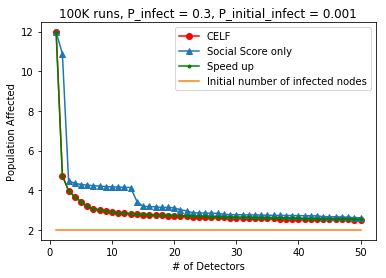

In [121]:
plt.plot(range(1, 51), celf_population_point001_point3, label="CELF", marker="o", color="red")
plt.plot(range(1, 51), social_population_point001_point3, label="Social Score only", marker="^")
plt.plot(range(1, 51), speedup_population_point001_point3, label="Speed up", marker=".", color="green")
plt.plot(range(1,51), np.ones(50)*2, label="Initial number of infected nodes")
plt.title("100K runs, P_infect = 0.3, P_initial_infect = 0.001")
plt.ylabel("Population Affected")
plt.xlabel("# of Detectors")
plt.legend()

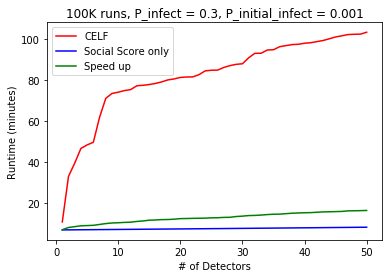

In [133]:
plt.plot(range(1,51), celf_population_runtimes_point001_point3, label="CELF", color="red")
plt.plot(range(1,51), [time + 7 for time in social_population_runtimes_point001_point3], label="Social Score only", color="blue")
plt.plot(range(1,51), [time + 7 for time in speedup_population_runtimes_point001_point3] , label="Speed up", color="green")
plt.title("100K runs, P_infect = 0.3, P_initial_infect = 0.001")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

p_initial = 0.005, p_infect = 0.5

In [91]:
celf_population_point005_point5, celf_population_runtimes_point005_point5, selected_detectors = celf_population_live_edges(0.005, 0.5, live_edges_200k_point005_point5[:100000], 50, debug=False )


Running CELF to minimize population affected w/ live edges
We have our first best node: 
[1874]
Runtime (minutes) = 34.4072666685
After doing CELF, we have found the 2th detector w/ best marginal gain = 1669
Population affected so far: 16.34258
Runtime (minutes) = 111.295650001
After doing CELF, we have found the 3th detector w/ best marginal gain = 453
Population affected so far: 14.64678
Runtime (minutes) = 179.923233334
After doing CELF, we have found the 4th detector w/ best marginal gain = 246
Population affected so far: 13.8353
Runtime (minutes) = 186.453849999
After doing CELF, we have found the 5th detector w/ best marginal gain = 1144
Population affected so far: 13.16287
Runtime (minutes) = 189.346833332
After doing CELF, we have found the 6th detector w/ best marginal gain = 1159
Population affected so far: 12.57561
Runtime (minutes) = 191.400233332
After doing CELF, we have found the 7th detector w/ best marginal gain = 1706
Population affected so far: 12.06882
Runtime (minu

In [92]:
social_population_point005_point5, social_population_runtimes_point005_point5 = social_population_live_edges(0.005, 0.5, live_edges_200k_point005_point5[:100000], 50 )


After doing Social Score, we have found the 1th detector = 1874
Population affected so far: 30.10218
Marginal gain = 30.10218
Runtime (minutes) = 0.07178333203
After doing Social Score, we have found the 2th detector = 1258
Population affected so far: 27.9238
Marginal gain = -2.17838
Runtime (minutes) = 0.141966664791
After doing Social Score, we have found the 3th detector = 1669
Population affected so far: 15.67246
Marginal gain = -12.25134
Runtime (minutes) = 0.212216667334
After doing Social Score, we have found the 4th detector = 999
Population affected so far: 15.34884
Marginal gain = -0.32362
Runtime (minutes) = 0.28188333114
After doing Social Score, we have found the 5th detector = 511
Population affected so far: 15.16735
Marginal gain = -0.18149
Runtime (minutes) = 0.353116667271
After doing Social Score, we have found the 6th detector = 852
Population affected so far: 15.06232
Marginal gain = -0.10503
Runtime (minutes) = 0.424550000827
After doing Social Score, we have found

In [93]:
speedup_population_point005_point5, speedup_population_runtimes_point005_point5, selected_detectors = speedup_population_live_edges(0.005, 0.5, live_edges_200k_point005_point5[:100000], 50, "socialScore_modified_unpruned.txt", debug=False )


Running Speedup to minimize population affected w/ live edges
We have our first best node: 
[1874]
Runtime (minutes) = 0.271799997489
After doing speed up, we have found the 2th detector w/ best marginal gain = 1669
Population affected so far: 16.34258
Runtime (minutes) = 3.44483333429
After doing speed up, we have found the 3th detector w/ best marginal gain = 453
Population affected so far: 14.64678
Runtime (minutes) = 4.49744999806
After doing speed up, we have found the 4th detector w/ best marginal gain = 1144
Population affected so far: 13.84856
Runtime (minutes) = 5.61963333289
After doing speed up, we have found the 5th detector w/ best marginal gain = 1159
Population affected so far: 13.11456
Runtime (minutes) = 5.89958333174
After doing speed up, we have found the 6th detector w/ best marginal gain = 1706
Population affected so far: 12.5049
Runtime (minutes) = 6.32411666711
After doing speed up, we have found the 7th detector w/ best marginal gain = 895
Population affected so

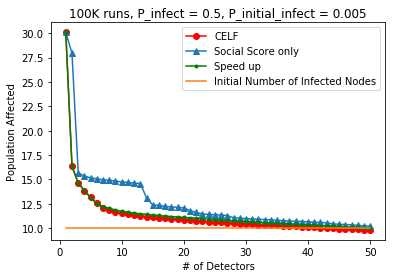

In [126]:
plt.plot(range(1, 51), celf_population_point005_point5, label="CELF", color="red", marker="o")
plt.plot(range(1, 51), social_population_point005_point5, label="Social Score only", marker="^")
plt.plot(range(1, 51), speedup_population_point005_point5, label="Speed up", marker=".", color="green")
plt.plot(range(1,51), np.ones(50)*10, label="Initial Number of Infected Nodes")
plt.title("100K runs, P_infect = 0.5, P_initial_infect = 0.005")
plt.ylabel("Population Affected")
plt.xlabel("# of Detectors")
plt.legend()

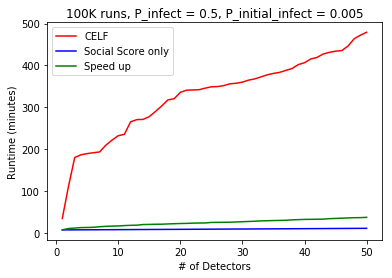

In [134]:
plt.plot(range(1,51), celf_population_runtimes_point005_point5, label="CELF", color="red")
plt.plot(range(1,51), [time + 7 for time in social_population_runtimes_point005_point5], label="Social Score only", color="blue")
plt.plot(range(1,51), [time + 7 for time in speedup_population_runtimes_point005_point5], label="Speed up", color="green")

plt.title("100K runs, P_infect = 0.5, P_initial_infect = 0.005")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

p_initial = 0.005, p_infect = 0.3

In [11]:
celf_population_point005_point3, celf_population_runtimes_point005_point3, selected_detectors = celf_population_live_edges(0.005, 0.3, live_edges_200k_point005_point3[:10000], 40, debug=False )


Running CELF to minimize population affected w/ live edges
We have our first best node: 
[1874]
Runtime (minutes) = 2.75221666495
After doing CELF, we have found the 2th detector w/ best marginal gain = 1669
Population affected so far: 15.9944
Runtime (minutes) = 6.69564999739
After doing CELF, we have found the 3th detector w/ best marginal gain = 453
Population affected so far: 14.4375
Runtime (minutes) = 11.012833333
After doing CELF, we have found the 4th detector w/ best marginal gain = 1144
Population affected so far: 13.6214
Runtime (minutes) = 11.2374333302
After doing CELF, we have found the 5th detector w/ best marginal gain = 1159
Population affected so far: 12.947
Runtime (minutes) = 11.356099999
After doing CELF, we have found the 6th detector w/ best marginal gain = 1706
Population affected so far: 12.3931
Runtime (minutes) = 11.4965333303
After doing CELF, we have found the 7th detector w/ best marginal gain = 246
Population affected so far: 12.0432
Runtime (minutes) = 1

In [9]:
social_population_point005_point3, social_population_runtimes_point005_point3 = social_population_live_edges(0.005, 0.3, live_edges_200k_point005_point3[:100000], 40 )


After doing Social Score, we have found the 1th detector = 1874
Population affected so far: 28.29538
Marginal gain = 28.29538
Runtime (minutes) = 0.0420500000318
After doing Social Score, we have found the 2th detector = 1258
Population affected so far: 26.11428
Marginal gain = -2.1811
Runtime (minutes) = 0.0841333349546
After doing Social Score, we have found the 3th detector = 1669
Population affected so far: 15.30384
Marginal gain = -10.81044
Runtime (minutes) = 0.125516668955
After doing Social Score, we have found the 4th detector = 999
Population affected so far: 14.9743
Marginal gain = -0.32954
Runtime (minutes) = 0.168333335718
After doing Social Score, we have found the 5th detector = 511
Population affected so far: 14.81239
Marginal gain = -0.16191
Runtime (minutes) = 0.21028333505
After doing Social Score, we have found the 6th detector = 852
Population affected so far: 14.69897
Marginal gain = -0.11342
Runtime (minutes) = 0.252383335431
After doing Social Score, we have fou

In [10]:
speedup_population_point005_point3, speedup_population_runtimes_point005_point3, selected_detectors = speedup_population_live_edges(0.005, 0.3, live_edges_200k_point005_point3[:100000], 40, "socialScore_modified_unpruned.txt", debug=False )


Running Speedup to minimize population affected w/ live edges
We have our first best node: 
[1874]
Runtime (minutes) = 0.248233334223
After doing speed up, we have found the 2th detector w/ best marginal gain = 1669
Population affected so far: 15.9686
Runtime (minutes) = 2.10853333473
After doing speed up, we have found the 3th detector w/ best marginal gain = 453
Population affected so far: 14.41972
Runtime (minutes) = 2.80308333238
After doing speed up, we have found the 4th detector w/ best marginal gain = 1144
Population affected so far: 13.61066
Runtime (minutes) = 3.34101666609
After doing speed up, we have found the 5th detector w/ best marginal gain = 1159
Population affected so far: 12.9465
Runtime (minutes) = 3.65843333403
After doing speed up, we have found the 6th detector w/ best marginal gain = 1706
Population affected so far: 12.41316
Runtime (minutes) = 3.91463333368
After doing speed up, we have found the 7th detector w/ best marginal gain = 1258
Population affected so

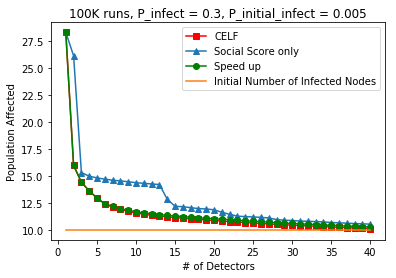

In [130]:
plt.plot(range(1, 41), celf_population_point005_point3, label="CELF", marker = "s", color="red")
plt.plot(range(1, 41), social_population_point005_point3, label="Social Score only", marker = "^")
plt.plot(range(1, 41), speedup_population_point005_point3, label="Speed up", marker="o", color="green")
plt.plot(range(1,41), np.ones(40)*10, label="Initial Number of Infected Nodes")
plt.title("100K runs, P_infect = 0.3, P_initial_infect = 0.005")
plt.ylabel("Population Affected")
plt.xlabel("# of Detectors")
plt.legend()

In [12]:
celf_10k_runtime =  celf_population_runtimes_point005_point3

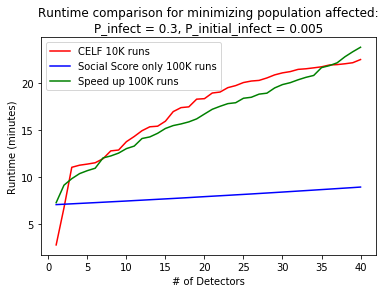

In [17]:
plt.plot(range(1,41), celf_10k_runtime, label="CELF 10K runs", color="red")
plt.plot(range(1,41), [runtime + 7 for runtime in social_population_runtimes_point005_point3], label="Social Score only 100K runs", color="blue")
plt.plot(range(1,41), [runtime + 7 for runtime in speedup_population_runtimes_point005_point3], label="Speed up 100K runs", color="green")
plt.title("Runtime comparison for minimizing population affected:\nP_infect = 0.3, P_initial_infect = 0.005")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

In [3]:
social_population_runtimes_point005_point3

NameError: name 'social_population_runtimes_point005_point3' is not defined

# Saving celf output

In [132]:
pickle.dump(celf_population_point001_point3, open("celf_population_point001_point3", "wb"))
pickle.dump(celf_population_runtimes_point001_point3, open("celf_population_runtimes_point001_point3", "wb"))
pickle.dump(celf_population_point005_point5, open("celf_population_point005_point5", "wb"))
pickle.dump(celf_population_runtimes_point005_point5, open("celf_population_runtimes_point005_point5", "wb"))
pickle.dump(celf_population_point005_point3, open("celf_population_point005_point3", "wb"))
pickle.dump(celf_population_runtimes_point005_point3, open("celf_population_runtimes_point005_point3", "wb"))
